In [131]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from lag_llama.gluon.estimator import LagLlamaEstimator

from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.model.forecast import SampleForecast, QuantileForecast
from sklearn.metrics import mean_absolute_percentage_error
import copy
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.torch.model.deepar.module import DeepARModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
df = pd.read_parquet("../data/tte_data.parquet")
or_df = df.copy()
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 366)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 366)
weather_features = [
    "precip_",
    "temp",
    "solarradiation",
    "solarproduction",
    "humidity",
    "precipcover",
]
vacs_feature = ["ferie", "vacances_wallonie", "vacances_flandre"]
known_features = [
    # "hour",
    # "dayofweek",
    # "month",
    # "dayofyear_cos",
    # "dayofyear_sin",
    "ferie",
    "vacances_wallonie",
    "vacances_flandre",
]
df[vacs_feature] = df[vacs_feature].astype(int)
for w in weather_features:
    df[f"D1_{w}_Q50"] = df[
        [c for c in df.columns if "D1" in c and w in c]
    ].mean(axis=1)
    df[f"D1_{w}_Q10"] = df[
        [c for c in df.columns if "D1" in c and w in c]
    ].quantile(0.1, axis=1)
    df[f"D1_{w}_Q90"] = df[
        [c for c in df.columns if "D1" in c and w in c]
    ].quantile(0.9, axis=1)
    df[f"actual_{w}_Q50"] = df[
        [c for c in df.columns if "actual" in c and w in c]
    ].mean(axis=1)
    df[f"actual_{w}_Q10"] = df[
        [c for c in df.columns if "actual" in c and w in c]
    ].quantile(0.1, axis=1)
    df[f"actual_{w}_Q90"] = df[
        [c for c in df.columns if "actual" in c and w in c]
    ].quantile(0.9, axis=1)

future_features = [c for c in df.columns if "Q" in c and "D" in c]
past_features = [c for c in df.columns if "Q" in c and "actual" in c]


print(f"Number of features {len(future_features + past_features)}")

df["scaled_allocs"] = df["prov_allocs"] / df["scale_EAV_total"]
data = df[
    ["scaled_allocs", "scale_EAV_total"] + future_features + past_features + known_features
]
past_features += known_features
future_features += known_features
data.index = data.index.tz_convert("UTC")
df = data.fillna(0)

Number of features 36


In [133]:
train_df = df.loc["2022-03":"2023-02"]
train_df.index = train_df.index.tz_localize(None)

full_df = df.loc["2022-03":"2023-03"].reset_index()
full_df["timepoint"] = full_df["timepoint"].dt.tz_localize(None)

val_df = df.loc["2023-02":"2023-03"].reset_index()
val_df["timepoint"] = val_df["timepoint"].dt.tz_localize(None)

train_df

,scaled_allocs,scale_EAV_total,D1_precip__Q50,D1_precip__Q10,D1_precip__Q90,D1_temp_Q50,D1_temp_Q10,D1_temp_Q90,D1_solarradiation_Q50,D1_solarradiation_Q10,...,actual_solarproduction_Q90,actual_humidity_Q50,actual_humidity_Q10,actual_humidity_Q90,actual_precipcover_Q50,actual_precipcover_Q10,actual_precipcover_Q90,ferie,vacances_wallonie,vacances_flandre
timepoint,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,8.160194,29430.851948,0.0,0.0,0.0,1.990476,1.03,2.84,0.0,0.0,...,0.0,68.081905,57.591,76.886,4.167143,0.0,12.500000,0,1,1
2022-03-01 01:00:00,7.417400,29430.851948,0.0,0.0,0.0,1.828571,0.84,2.68,0.0,0.0,...,0.0,68.326667,58.065,79.410,4.167143,0.0,12.500000,0,1,1
2022-03-01 02:00:00,7.229154,29430.851948,0.0,0.0,0.0,1.704762,0.91,2.70,0.0,0.0,...,0.0,67.095238,57.067,76.600,4.167143,0.0,12.500000,0,1,1
2022-03-01 03:00:00,7.276809,29430.851948,0.0,0.0,0.0,1.661905,0.62,2.88,0.0,0.0,...,0.0,68.025238,57.025,78.840,4.167143,0.0,12.500000,0,1,1
2022-03-01 04:00:00,7.531331,29430.851948,0.0,0.0,0.0,1.714286,0.07,3.36,0.0,0.0,...,0.0,67.830000,57.476,77.970,4.167143,0.0,12.500000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,14.465500,26812.042339,0.0,0.0,0.0,0.776190,-0.20,1.60,0.0,0.0,...,0.0,60.556190,55.884,63.368,0.992381,0.0,3.534476,0,1,0
2023-02-28 20:00:00,13.204530,26812.042339,0.0,0.0,0.0,0.252381,-0.69,1.00,0.0,0.0,...,0.0,64.684286,61.467,68.086,0.992381,0.0,3.534476,0,1,0
2023-02-28 21:00:00,12.129044,26812.042339,0.0,0.0,0.0,-0.133333,-1.09,0.60,0.0,0.0,...,0.0,66.524762,62.220,71.480,0.992381,0.0,3.534476,0,1,0


In [134]:
from timeseries import TimeSeriesDataset
from torch.utils.data import DataLoader


context_length = 7 * 24
prediction_length = 14 * 24
# Example usage
train_dataset = TimeSeriesDataset(
    df=train_df,
    target_col="scaled_allocs",
    past_features=past_features,
    future_features=future_features,
    context_length=context_length,
    prediction_length=prediction_length,
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [135]:
deepar_model = DeepARModel(
    freq="1h",
    context_length=context_length,
    prediction_length=prediction_length,
    lags_seq=list(range(1, 2)),
    num_feat_dynamic_real=len(future_features),
)

In [136]:
import torch.optim as optim

# Define optimizer
optimizer = optim.Adam(deepar_model.parameters(), lr=1e-3)

# Define the training device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deepar_model.to(device)

gluonts.torch.model.deepar.module.DeepARModel(cardinality=[], context_length=168, default_scale=None, distr_output=gluonts.torch.distributions.studentT.StudentTOutput(beta=0.0), dropout_rate=0.1, embedding_dimension=None, freq='1h', hidden_size=40, lags_seq=[1], nonnegative_pred_samples=False, num_feat_dynamic_real=21, num_feat_static_cat=0, num_feat_static_real=0, num_layers=2, num_parallel_samples=100, prediction_length=336, scaling=True)

In [137]:
num_epochs = 20  # Set number of epochs
deepar_model.train()  # Set model to training mode

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in train_loader:
        # Move batch to the device
        past_target = batch["past_target"].to(device)
        future_target = batch["future_target"].to(device)
        past_time_feat = batch["past_time_feat"].to(device)
        future_time_feat = batch["future_time_feat"].to(device)
        past_observed_values = batch["past_observed_values"].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = deepar_model.loss(
            feat_static_cat=torch.empty(past_target.shape[0], 0).to(device),
            feat_static_real=torch.empty(past_target.shape[0], 0).to(device),
            past_time_feat=past_time_feat,
            past_target=past_target,
            past_observed_values=past_observed_values,
            future_time_feat=future_time_feat,
            future_target=future_target,
            future_observed_values=torch.ones_like(future_target).to(device),
        )

        # Backward pass and optimization
        loss = torch.mean(
            loss
        )  # Or use torch.sum(loss) if that's more appropriate

        loss.backward()
        optimizer.step()

        # Accumulate the total loss
        total_loss += loss.item()

    print(
        f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}"
    )

Epoch 1/20, Loss: 1.9949399334515712
Epoch 2/20, Loss: 1.7711038875949474
Epoch 3/20, Loss: 1.7269665915374608
Epoch 4/20, Loss: 1.6692983722963999
Epoch 5/20, Loss: 1.634071675612945
Epoch 6/20, Loss: 1.6346652105797168
Epoch 7/20, Loss: 1.6031340314436329
Epoch 8/20, Loss: 1.6007410976313805
Epoch 9/20, Loss: 1.5940910129584083
Epoch 10/20, Loss: 1.5818520130575164
Epoch 11/20, Loss: 1.5795794487461563
Epoch 12/20, Loss: 1.5680354493995046
Epoch 13/20, Loss: 1.5590577534464902
Epoch 14/20, Loss: 1.5631909991881645
Epoch 15/20, Loss: 1.5648858979228855
Epoch 16/20, Loss: 1.551747752483501
Epoch 17/20, Loss: 1.5514482061068218
Epoch 18/20, Loss: 1.5412266101948051
Epoch 19/20, Loss: 1.531016193850096
Epoch 20/20, Loss: 1.527260225641635


In [140]:
def forecast(
    model,
    past_target,
    past_time_feat,
    future_time_feat,
    feat_static_cat=None,
    feat_static_real=None,
):
    """
    Perform forecast using the model.

    Arguments:
    model -- Trained DeepAR model
    past_target -- Tensor of past target values (shape: [batch_size, context_length])
    past_time_feat -- Tensor of past dynamic features (shape: [batch_size, context_length, num_features])
    future_time_feat -- Tensor of future dynamic features (shape: [batch_size, prediction_length, num_features])
    feat_static_cat -- Optional tensor of static categorical features
    feat_static_real -- Optional tensor of static real-valued features

    Returns:
    predicted_values -- Predicted future values (shape: [batch_size, prediction_length])
    """
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get model device (CPU or GPU)

    # Move inputs to device
    past_target = past_target.to(device)
    past_time_feat = past_time_feat.to(device)
    future_time_feat = future_time_feat.to(device)

    if feat_static_cat is not None:
        feat_static_cat = feat_static_cat.to(device)
    if feat_static_real is not None:
        feat_static_real = feat_static_real.to(device)

    # Use torch.no_grad() to disable gradient computation for inference
    with torch.no_grad():
        predictions = model(
            feat_static_cat=feat_static_cat,
            feat_static_real=feat_static_real,
            past_time_feat=past_time_feat,
            past_target=past_target,
            past_observed_values=torch.ones_like(past_target).to(device),
            future_time_feat=future_time_feat,
        )

        mean_predictions = predictions.mean(dim=1)[..., -24:]

    return mean_predictions.cpu().numpy().flatten(order="C")

In [139]:
preds = []
for batch in islice(train_loader, 5):  
    past_target = batch["past_target"].to(device)
    past_time_feat = batch["past_time_feat"].to(device)
    future_time_feat = batch["future_time_feat"].to(device)
    feat_static_cat = batch.get("feat_static_cat", None)  # Optional
    feat_static_real = batch.get("feat_static_real", None)  # Optional
    predicted_values = forecast(
        model=deepar_model,
        past_target=past_target,
        past_time_feat=past_time_feat,
        future_time_feat=future_time_feat,
        feat_static_cat=feat_static_cat,
        feat_static_real=feat_static_real,
    )

    preds.append[predicted_values]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [141]:
val_dataset = TimeSeriesDataset(
    df=val_df,
    target_col="scaled_allocs",
    past_features=past_features,
    future_features=future_features,
    context_length=context_length,
    prediction_length=prediction_length,
)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [159]:
i = 0
preds = np.array([])
for batch in islice(val_loader, 1):

    past_target = batch["past_target"].to(device)
    print(past_target[0, 23 - i])
    i += 1
    past_time_feat = batch["past_time_feat"].to(device)
    future_time_feat = batch["future_time_feat"].to(device)
    feat_static_cat = batch.get("feat_static_cat", None)  # Optional
    feat_static_real = batch.get("feat_static_real", None)  # Optional
    predicted_values = forecast(
        model=deepar_model,
        past_target=past_target,
        past_time_feat=past_time_feat,
        future_time_feat=future_time_feat,
        feat_static_cat=feat_static_cat,
        feat_static_real=feat_static_real,
    )

    preds = np.hstack((preds, predicted_values))

tensor(9.0059)


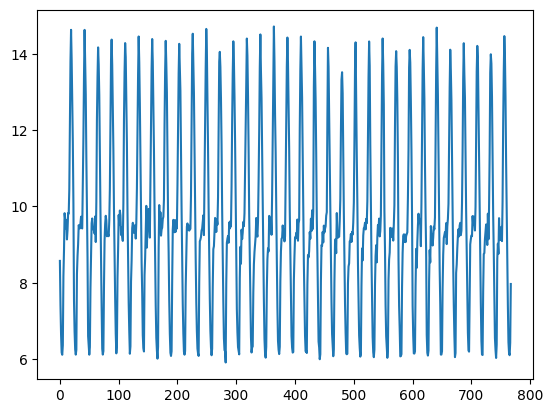

In [160]:
plt.plot(preds)

In [155]:
np.hstack((preds_, predicted_values))

array([ 8.58336544,  9.06874371,  8.94299507,  9.12630081,  8.87277603,
        9.66280174,  9.47356796,  9.40873337,  8.74980545, 10.95353889,
       12.28664875, 13.54363728, 13.16046429, 12.47334385, 11.14236927,
        9.55525875,  8.38508034,  7.16343737,  6.35736036,  5.90090799,
        5.78413343,  6.01640368,  7.69571161,  9.07284164,  8.8637991 ,
        8.9772625 ,  9.16300678,  8.88870049,  8.98136806,  9.44516087,
        8.95433331,  9.38532257, 11.03299809, 12.36153793, 13.69068146,
       13.39963722, 12.4418087 , 11.11339569,  9.52595997,  8.37796116,
        7.08758307,  6.40375805,  6.00313616,  5.86784649,  6.01918077,
        7.89675236,  9.07590103,  9.6159687 ,  9.17323208,  9.33109093,
        9.38462734,  9.15153122,  9.09420109,  9.10356426,  9.16366196,
       10.84297943, 12.51102448, 13.80164051, 13.11207771, 12.47683144,
       10.80041504,  9.66198921,  8.29882336,  7.1275835 ,  6.37904787,
        6.11844826,  6.06203413,  6.0744319 ,  7.86734438,  8.89

In [152]:
predicted_values

array([ 8.583365 ,  9.068744 ,  8.942995 ,  9.126301 ,  8.872776 ,
        9.662802 ,  9.473568 ,  9.408733 ,  8.749805 , 10.953539 ,
       12.286649 , 13.543637 , 13.160464 , 12.473344 , 11.142369 ,
        9.555259 ,  8.38508  ,  7.1634374,  6.3573604,  5.900908 ,
        5.7841334,  6.0164037,  7.6957116,  9.072842 ,  8.863799 ,
        8.9772625,  9.163007 ,  8.8887005,  8.981368 ,  9.445161 ,
        8.954333 ,  9.385323 , 11.032998 , 12.361538 , 13.690681 ,
       13.399637 , 12.441809 , 11.113396 ,  9.52596  ,  8.377961 ,
        7.087583 ,  6.403758 ,  6.003136 ,  5.8678465,  6.019181 ,
        7.8967524,  9.075901 ,  9.615969 ,  9.173232 ,  9.331091 ,
        9.384627 ,  9.151531 ,  9.094201 ,  9.103564 ,  9.163662 ,
       10.842979 , 12.511024 , 13.8016405, 13.112078 , 12.476831 ,
       10.800415 ,  9.661989 ,  8.298823 ,  7.1275835,  6.379048 ,
        6.1184483,  6.062034 ,  6.074432 ,  7.8673444,  8.891387 ,
       10.042591 ,  9.902316 ,  9.21394  ,  9.116245 ,  8.9613